In [1]:
import pandas as pd
from adjustText import adjust_text
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.ensemble._iforest import _average_path_length
import shap
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_columns', None)

# Loading combined fbref/ transfermarkt data

In [2]:
df = pd.read_parquet(os.path.join('data', 'fbref_tm_combined.parquet'))

In [3]:
# Drop some negative columns that you might not want to identify players based on, e.g. number of yellow cards.
# penalties are rare so they tend to show up a lot in the outliers so removed for showing more interesting things
to_drop = ['performance_off', 'performance_crdy', 'performance_2crdy', 'performance_crdr', 'performance_fls',
           'performance_og', 'performance_pkcon', 'performance_pkwon', 'standard_fk', 'pass_types_fk', 'vs_dribbles_att',
           'outcomes_off', 'outcomes_out', 'outcomes_int', 'outcomes_blocks', 'standard_pk', 'playing_time_mn/mp', 'short_att',
           'pass_types_press', 'body_parts_right', 'body_parts_other', 'body_parts_head', 'a-xa', 'expected_np:g-xg',
           'aerial_duels_lost', 'miscon', 'dispos', 'err', 'standard_pkatt',]
df.drop(to_drop, axis='columns', inplace=True)
# drop gca_types_gca_og_for as usually very low (mostly 0, but ocassionally 1 or 2)
df.drop('gca_types_og', axis='columns', inplace=True)

# Drop centre backs / goalkeepers

Centre-back stats are notoriously hard and goalkeepers are judged differently so we drop them here.

In [4]:
mask_remove = ((df.position_tm == 'Centre-Back') | (df.pos == 'GK')) & (df.pos.isin(['GK', 'DF']))
df = df[~mask_remove].copy()

# Drop players with fewer than 700 minutes played over last two years

This is an arbitrary cut-off point (around 7.8 games)

In [5]:
# commented out as already filtered in 03_combine_transfermarkt_and_fbref.ipynb
#df = df[df.playing_time_min >= 700].copy()
df.reset_index(drop=True, inplace=True)

# Add a code for the transfermarkt position

Note there is some disagreement between fbref and transfermarkt positions but it is broadly the same

In [6]:
df.loc[df.position_tm.str.contains('Midfield'), 'position_code'] = 0
df.loc[df.position_tm.str.contains('Back'), 'position_code'] = 1
df.loc[df.position_tm.str.contains('Striker'), 'position_code'] = 2
df.loc[df.position_tm.str.contains('Winger'), 'position_code'] = 2
df.loc[df.position_tm.str.contains('Forward'), 'position_code'] = 2

# Check for highly correlated columns and drop them

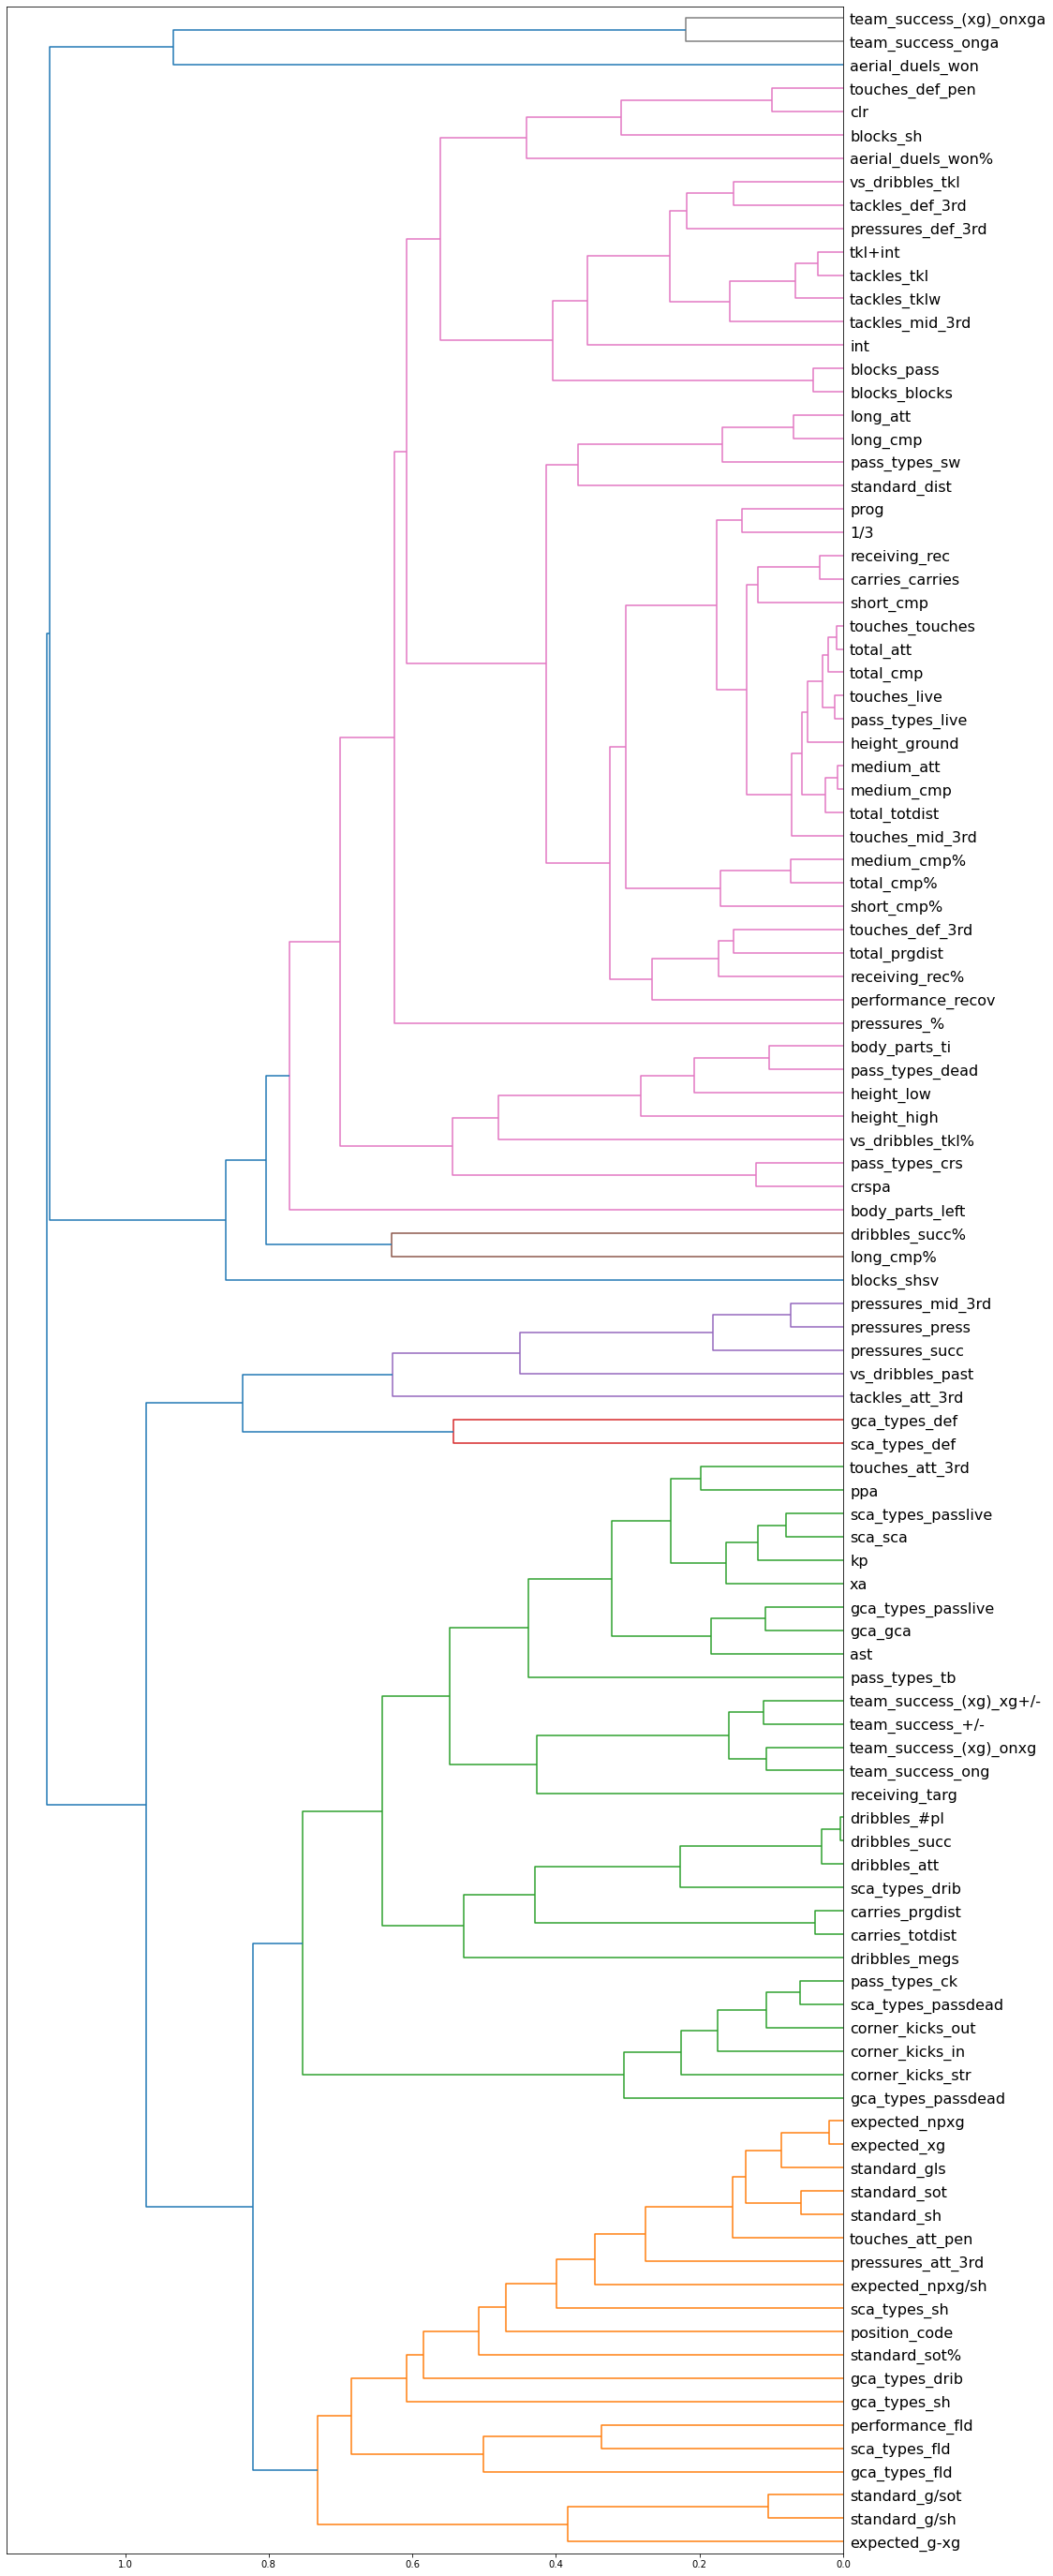

In [7]:
# https://stackoverflow.com/questions/34175462/dendrogram-using-pandas-and-scipy
corr_condensed = squareform(1 - df[df.columns[29:]].corr())
z = linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 50))
labels = list(df[df.columns[29:]].columns)
dend = dendrogram(z, orientation='left', labels=labels, leaf_font_size=16)

In [8]:
corr_cols = ['pass_types_live', 'medium_att', 'total_att', 'receiving_rec', 'long_att', 'medium_cmp%', 'pass_types_crs',
             'touches_def_pen',  'tackles_tkl', 'vs_dribbles_past','blocks_pass',  'body_parts_ti',  'tackles_mid_3rd', 
             'prog', 'expected_xg','standard_sh',  'standard_g/sot',  'expected_g-xg', 'kp', 'sca_types_passlive',
             'team_success_+/-','gca_types_passlive', 'team_success_ong', 'dribbles_#pl', 'carries_totdist', 'medium_cmp',
             'total_cmp','tkl+int', 'team_success_(xg)_onxg', 'standard_sot', 'height_ground', 'touches_mid_3rd',
             'corner_kicks_in', 'corner_kicks_out', 'corner_kicks_str', 'touches_def_3rd', 'team_success_onga', 'dribbles_succ',
             'gca_gca','gca_types_passdead', 'sca_sca', 'standard_gls', 'ast', 'pass_types_dead', 'receiving_rec%',
             'gca_types_drib', 'gca_types_sh', 'gca_types_fld', 'short_cmp%', 'total_totdist', 'total_cmp%', 'height_low',
             'long_cmp', 'touches_live', 'dribbles_att', 'pass_types_ck', 'pressures_press', 'touches_touches']
df.drop(corr_cols, axis='columns', inplace=True)

In [9]:
print('Columns left:', len(df.columns[29:]))
print(list(df.columns[29:]))

Columns left: 51
['team_success_(xg)_onxga', 'team_success_(xg)_xg+/-', 'tackles_tklw', 'tackles_def_3rd', 'tackles_att_3rd', 'vs_dribbles_tkl', 'pressures_succ', 'pressures_def_3rd', 'pressures_mid_3rd', 'pressures_att_3rd', 'blocks_blocks', 'blocks_sh', 'blocks_shsv', 'int', 'clr', 'sca_types_passdead', 'sca_types_drib', 'sca_types_sh', 'sca_types_fld', 'sca_types_def', 'gca_types_def', 'performance_fld', 'performance_recov', 'aerial_duels_won', 'total_prgdist', 'short_cmp', 'xa', '1/3', 'ppa', 'crspa', 'pass_types_tb', 'pass_types_sw', 'height_high', 'body_parts_left', 'touches_att_3rd', 'touches_att_pen', 'dribbles_megs', 'carries_carries', 'carries_prgdist', 'receiving_targ', 'expected_npxg', 'standard_dist', 'vs_dribbles_tkl%', 'pressures_%', 'aerial_duels_won%', 'long_cmp%', 'dribbles_succ%', 'standard_g/sh', 'expected_npxg/sh', 'standard_sot%', 'position_code']


# Change some values as we don't want to flag people as outliers for their poor stats (truncate stats for bottom quantile if more is better or top quantile if fewer is better)

In [10]:
X = df[df.columns[29:]].copy()
# fill in missing values with the median values
X = X.fillna(X.median())
# for goals allowed stats if in the top 50% change the value
cols_fewer_better = ['team_success_(xg)_onxga', 'standard_dist']
mask1 = X[cols_fewer_better] > X[cols_fewer_better].quantile(0.5)
# for other stats is in the bottom quantile change value
cols_more_better = [col for col in X.columns if col not in cols_fewer_better]
mask2 = X[cols_more_better] < X[cols_more_better].quantile(0.25)
mask = pd.concat([mask1, mask2], axis='columns')
quantile_values = pd.concat([X[cols_fewer_better].quantile(0.5), X[cols_more_better].quantile(0.25)])
X.mask(mask, quantile_values, axis='columns', inplace=True)

# Find outliers using isolation forest

In [11]:
clf = IsolationForest(random_state=42, contamination=0.1)
y_pred = clf.fit(X)
df['forest_score'] = clf.score_samples(X)

# Calculate shap values (to explain the outliers)

In [12]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
df_shap = pd.DataFrame(shap_values, columns=X.columns)

The sklearn.ensemble.iforest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


# Get the five column names contributing to the the smallest (most negative) difference and their values

In [13]:
df['stat1_name'] = df_shap.T.idxmin()
df['stat1'] = df.lookup(df.index, df['stat1_name'])
df['stat2_name'] = df_shap.T.apply(lambda x: x.nsmallest(2).idxmax())
df['stat2'] = df.lookup(df.index, df['stat2_name'])
df['stat3_name'] = df_shap.T.apply(lambda x: x.nsmallest(3).idxmax())
df['stat3'] = df.lookup(df.index, df['stat3_name'])
df['stat4_name'] = df_shap.T.apply(lambda x: x.nsmallest(4).idxmax())
df['stat4'] = df.lookup(df.index, df['stat4_name'])
df['stat5_name'] = df_shap.T.apply(lambda x: x.nsmallest(5).idxmax())
df['stat5'] = df.lookup(df.index, df['stat5_name'])

# Sort by the score

In [14]:
df.sort_values('forest_score', inplace=True)
df.reset_index(drop=True, inplace=True)

# Subset columns

In [15]:
cols = ['player_tm', 'player', 'squad_tm', 'age_at_2020_12_01_tm', 'market_value_euro_millions_tm','league_tm',
        'year_tm', 'dob_tm', 'position_tm', 'pos', 'height_tm', 'foot_tm', 
        'joined_tm', 'contract_expires_tm', 
        'player_link_tm', 'player_link_fbref', '90s', 'playing_time_mp', 'playing_time_min',
        'forest_score', 'stat1_name', 'stat1', 'stat2_name', 'stat2', 'stat3_name', 'stat3',
        'stat4_name', 'stat4', 'stat5_name', 'stat5']
df_subset = df[cols].copy()

In [16]:
df_subset.rename({'player_tm': 'player_name_transfermarkt',
                  'player': 'player_name_fbref',
                  'dob_tm': 'dob_transfermarkt',
                  'age_at_2020_12_01_tm': 'age_years_at_2020_12_01',
                  'position_tm': 'position_transfermarkt',
                  'pos': 'position_fbref',
                  'height_tm': 'height_transfermarkt',
                  'foot_tm': 'foot_transfermarkt',
                  'squad_tm': 'squad_transfermarkt', 
                  'league_tm': 'league_transfermarkt',
                  'joined_tm': 'joined_transfermarkt',
                  'contract_expires_tm': 'contract_expires_transfermarkt',
                  'market_value_euro_millions_tm': 'market_value_euros_millions', 
                  'year_tm': 'year_of_valuation',
                  'player_link_tm': 'player_link_transfermarkt',
                  'player_link_fbref': 'player_link_fbref'}, axis='columns', inplace=True)

# Show top 30 outliers

In [17]:
df_subset.head(30)

,player_name_transfermarkt,player_name_fbref,squad_transfermarkt,age_years_at_2020_12_01,market_value_euros_millions,league_transfermarkt,year_of_valuation,dob_transfermarkt,position_transfermarkt,position_fbref,height_transfermarkt,foot_transfermarkt,joined_transfermarkt,contract_expires_transfermarkt,player_link_transfermarkt,player_link_fbref,90s,playing_time_mp,playing_time_min,forest_score,stat1_name,stat1,stat2_name,stat2,stat3_name,stat3,stat4_name,stat4,stat5_name,stat5
0,Lionel Messi,Lionel Messi,Barcelona,33.4,100.0,LaLiga,2020,1987-06-24,Right Winger,"FW,MF",1.70,left,2005-07-01,2021-06-30,/lionel-messi/profil/spieler/28003,/en/players/d70ce98e/Lionel-Messi,72.6,78.0,6538.0,-0.625842,body_parts_left,59.826,pass_types_tb,1.294,sca_types_drib,1.211,touches_att_3rd,47.794,carries_prgdist,274.625
1,Marco Verratti,Marco Verratti,Paris S-G,28.1,60.0,Ligue 1,2020,1992-11-05,Central Midfield,MF,1.65,right,2012-07-18,2024-06-30,/marco-verratti/profil/spieler/102558,/en/players/1467af0d/Marco-Verratti,42.7,53.0,3842.0,-0.615042,receiving_targ,97.847,carries_carries,91.780,team_success_(xg)_xg+/-,1.548,pass_types_tb,0.960,short_cmp,49.053
2,Neymar,Neymar,Paris S-G,28.8,128.0,Ligue 1,2020,1992-02-05,Left Winger,"FW,MF",1.75,right,2017-08-03,2022-06-30,/neymar/profil/spieler/68290,/en/players/69384e5d/Neymar,36.9,39.0,3327.0,-0.615039,pass_types_tb,1.217,carries_prgdist,334.491,touches_att_3rd,45.717,team_success_(xg)_xg+/-,1.512,1/3,7.791
3,David Silva,David Silva,Real Sociedad,34.9,5.0,LaLiga,2020,1986-01-08,Attacking Midfield,MF,1.70,left,2020-08-17,2022-06-30,/david-silva/profil/spieler/35518,/en/players/e2716bd0/David-Silva,54.7,70.0,4919.0,-0.600005,team_success_(xg)_onxga,0.728,body_parts_left,62.007,receiving_targ,76.863,pass_types_tb,0.531,ppa,3.293
4,Thiago,Thiago Alcántara,Liverpool,29.6,48.0,Premier League,2020,1991-04-11,Central Midfield,MF,1.74,right,2020-09-18,2024-06-30,/thiago/profil/spieler/60444,/en/players/77e84962/Thiago-Alcantara,48.0,56.0,4314.0,-0.584098,team_success_(xg)_xg+/-,1.573,performance_recov,14.812,receiving_targ,81.092,1/3,10.139,team_success_(xg)_onxga,0.887
5,Kevin De Bruyne,Kevin De Bruyne,Manchester City,29.4,120.0,Premier League,2020,1991-06-28,Attacking Midfield,MF,1.81,right,2015-08-30,2023-06-30,/kevin-de-bruyne/profil/spieler/88755,/en/players/e46012d4/Kevin-De-Bruyne,51.1,64.0,4599.0,-0.576866,pass_types_tb,0.998,team_success_(xg)_xg+/-,1.552,ppa,3.894,touches_att_3rd,44.971,team_success_(xg)_onxga,0.810
6,Alphonso Davies,Alphonso Davies,Bayern Munich,20.1,80.0,Bundesliga,2020,2000-11-02,Left-Back,"DF,FW",1.83,left,2019-01-01,2025-06-30,/alphonso-davies/profil/spieler/424204,/en/players/d781d855/Alphonso-Davies,28.7,40.0,2585.0,-0.572078,performance_recov,14.797,dribbles_megs,0.487,team_success_(xg)_xg+/-,1.330,pressures_%,41.800,body_parts_left,50.101
7,Marquinhos,Marquinhos,Paris S-G,26.6,70.0,Ligue 1,2020,1994-05-14,Centre-Back,"DF,MF",1.83,right,2013-07-19,2024-06-30,/marquinhos/profil/spieler/181767,/en/players/d5f2f82b/Marquinhos,52.4,56.0,4716.0,-0.571097,standard_dist,9.200,team_success_(xg)_xg+/-,1.752,standard_g/sh,0.240,blocks_shsv,0.038,team_success_(xg)_onxga,0.874
8,James Rodríguez,James Rodríguez,Everton,29.4,35.0,Premier League,2020,1991-07-12,Attacking Midfield,"FW,MF",1.81,left,2020-09-07,2022-06-30,/james-rodriguez/profil/spieler/88103,/en/players/715bf047/James-Rodriguez,26.6,38.0,2397.0,-0.570716,body_parts_left,60.225,sca_types_passdead,1.239,team_success_(xg)_onxga,0.819,pass_types_sw,5.144,ppa,2.553
9,Riyad Mahrez,Riyad Mahrez,Manchester City,29.8,48.0,Premier League,2020,1991-02-21,Right Winger,"FW,DF",1.79,left,2018-07-10,2023-06-30,/riyad-mahrez/profil/spieler/171424,/en/players/892d5bb1/Riyad-Mahrez,44.8,69.0,4033.0,-0.567768,pass_types_tb,0.803,body_parts_left,48.537,team_success_(xg)_onxga,0.819,team_success_(xg)_xg+/-,1.442,ppa,3.057


# Show top 30 outliers aged 26 or under and valued at 15 mill or under

In [18]:
df_subset[(df_subset.age_years_at_2020_12_01 <= 26) & (df_subset.market_value_euros_millions <= 15)].head(30)

,player_name_transfermarkt,player_name_fbref,squad_transfermarkt,age_years_at_2020_12_01,market_value_euros_millions,league_transfermarkt,year_of_valuation,dob_transfermarkt,position_transfermarkt,position_fbref,height_transfermarkt,foot_transfermarkt,joined_transfermarkt,contract_expires_transfermarkt,player_link_transfermarkt,player_link_fbref,90s,playing_time_mp,playing_time_min,forest_score,stat1_name,stat1,stat2_name,stat2,stat3_name,stat3,stat4_name,stat4,stat5_name,stat5
13,Kevin Mbabu,Kevin Mbabu,Wolfsburg,25.6,8.5,Bundesliga,2020,1995-04-19,Right-Back,DF,1.84,right,2019-07-01,2023-06-30,/kevin-mbabu/profil/spieler/183321,/en/players/493924a7/Kevin-Mbabu,19.8,21.0,1786.0,-0.555624,standard_dist,10.800,standard_g/sh,0.300,blocks_shsv,0.050,crspa,0.857,tackles_def_3rd,1.965
24,Brahim Díaz,Brahim Díaz,Milan,21.3,14.0,Serie A,2020,1999-08-03,Attacking Midfield,"MF,FW",1.71,both,2020-09-04,2021-06-30,/brahim-diaz/profil/spieler/314678,/en/players/407feb71/Brahim-Diaz,9.1,23.0,823.0,-0.542473,gca_types_def,0.109,performance_fld,3.499,sca_types_drib,0.875,team_success_(xg)_xg+/-,1.236,sca_types_fld,0.875
29,Yusuf Yazici,Yusuf Yazıcı,Lille,23.8,13.0,Ligue 1,2020,1997-01-29,Attacking Midfield,"FW,MF",1.83,left,2019-08-06,2024-06-30,/yusuf-yazici/profil/spieler/386726,/en/players/f5c8b425/Yusuf-Yazici,13.1,31.0,1178.0,-0.537051,sca_types_passdead,1.681,dribbles_megs,0.458,gca_types_def,0.076,body_parts_left,42.250,xa,0.336
38,Silas Wamangituka,Silas Wamangituka,Stuttgart,21.2,10.0,Bundesliga,2020,1999-10-06,Right Winger,DF,1.89,right,2019-08-13,2024-06-30,/silas-wamangituka/profil/spieler/612826,/en/players/de4cac2d/Silas-Wamangituka,8.8,11.0,795.0,-0.525571,gca_types_def,0.226,standard_g/sh,0.250,sca_types_def,0.340,sca_types_sh,0.340,expected_npxg/sh,0.180
47,Nicolás Domínguez,Nicolás Domínguez,Bologna,22.4,14.0,Serie A,2020,1998-06-28,Central Midfield,MF,1.79,right,2019-08-30,2024-06-30,/nicolas-dominguez/profil/spieler/497291,/en/players/20b3a502/Nicolas-Dominguez,10.7,24.0,962.0,-0.520890,pressures_succ,8.607,tackles_def_3rd,2.152,tackles_tklw,2.339,performance_recov,13.191,pressures_mid_3rd,15.904
55,Andrés Cubas,Adrián Cubas,Nîmes,24.5,4.0,Ligue 1,2020,1996-05-22,Defensive Midfield,MF,1.66,right,2020-07-17,2024-06-30,/andres-cubas/profil/spieler/323872,/en/players/9b40a6ea/Adrian-Cubas,10.1,11.0,906.0,-0.512988,pressures_succ,9.338,tackles_tklw,2.583,dribbles_succ%,88.900,sca_types_def,0.199,vs_dribbles_tkl,1.490
57,Adnan Januzaj,Adnan Januzaj,Real Sociedad,25.8,10.0,LaLiga,2020,1995-02-05,Right Winger,"MF,FW",1.86,left,2017-07-12,2022-06-30,/adnan-januzaj/profil/spieler/177847,/en/players/4737cebe/Adnan-Januzaj,29.9,52.0,2691.0,-0.512546,team_success_(xg)_onxga,0.846,ppa,2.341,sca_types_sh,0.368,body_parts_left,33.445,gca_types_def,0.033
58,Juan Foyth,Juan Foyth,Villarreal,22.9,13.0,LaLiga,2020,1998-01-12,Centre-Back,"DF,MF",1.87,right,2020-10-04,2021-06-30,/juan-foyth/profil/spieler/480763,/en/players/6c7762c3/Juan-Foyth,10.8,17.0,961.0,-0.511664,tackles_def_3rd,3.278,clr,4.776,tackles_tklw,2.435,dribbles_succ%,85.700,long_cmp%,73.800
60,Adil Aouchiche,Adil Aouchiche,Saint-Étienne,18.4,10.0,Ligue 1,2020,2002-07-15,Attacking Midfield,"MF,FW",1.81,right,2020-07-20,2023-06-30,/adil-aouchiche/profil/spieler/569385,/en/players/b94b8be1/Adil-Aouchiche,8.3,13.0,750.0,-0.511121,sca_types_passdead,1.680,dribbles_megs,0.360,expected_npxg/sh,0.180,team_success_(xg)_onxga,0.948,dribbles_succ%,75.900
69,Maxence Caqueret,Maxence Caqueret,Lyon,20.8,12.0,Ligue 1,2020,2000-02-15,Central Midfield,MF,1.74,right,2018-12-14,2023-06-30,/maxence-caqueret/profil/spieler/395237,/en/players/f81ef10d/Maxence-Caqueret,13.5,19.0,1215.0,-0.507747,pressures_succ,9.704,tackles_tklw,2.370,pressures_mid_3rd,16.815,tackles_att_3rd,0.667,team_success_(xg)_onxga,0.844


# Show older outliers with a low valuation

In [19]:
df_subset[(df_subset.market_value_euros_millions < 5) & (df_subset.age_years_at_2020_12_01 > 26) & 
          (df_subset.age_years_at_2020_12_01 < 30)].head(15)

,player_name_transfermarkt,player_name_fbref,squad_transfermarkt,age_years_at_2020_12_01,market_value_euros_millions,league_transfermarkt,year_of_valuation,dob_transfermarkt,position_transfermarkt,position_fbref,height_transfermarkt,foot_transfermarkt,joined_transfermarkt,contract_expires_transfermarkt,player_link_transfermarkt,player_link_fbref,90s,playing_time_mp,playing_time_min,forest_score,stat1_name,stat1,stat2_name,stat2,stat3_name,stat3,stat4_name,stat4,stat5_name,stat5
15,Luke Ayling,Luke Ayling,Leeds United,29.3,3.5,Premier League,2020,1991-08-25,Right-Back,DF,1.83,right,2016-08-11,2023-06-30,/luke-ayling/profil/spieler/67420,/en/players/420d7c7d/Luke-Ayling,11.8,12.0,1059.0,-0.551644,blocks_shsv,0.085,blocks_sh,1.105,total_prgdist,500.822,carries_prgdist,243.739,1/3,6.119
77,Joshua Brenet,Joshua Brenet,Hoffenheim,26.7,2.4,Bundesliga,2020,1994-03-20,Right-Back,DF,1.81,right,2018-07-01,2022-06-30,/joshua-brenet/profil/spieler/207006,/en/players/2b5527c4/Joshua-Brenet,10.1,15.0,907.0,-0.506350,standard_sot%,70.000,standard_g/sh,0.200,pressures_%,37.400,standard_dist,14.400,expected_npxg/sh,0.170
82,Jonathan Clauss,Jonathan Clauss,Lens,28.2,1.5,Ligue 1,2020,1992-09-25,Right-Back,DF,1.78,right,2020-07-01,2023-06-30,/jonathan-clauss/profil/spieler/175639,/en/players/5219ab4a/Jonathan-Clauss,8.8,10.0,790.0,-0.505469,gca_types_def,0.114,tackles_att_3rd,0.797,ppa,2.278,crspa,0.911,sca_types_def,0.228
93,Laurent Abergel,Laurent Abergel,Lorient,27.8,1.8,Ligue 1,2020,1993-02-01,Defensive Midfield,MF,1.70,right,2019-07-26,2023-06-30,/laurent-abergel/profil/spieler/238626,/en/players/31626657/Laurent-Abergel,13.0,14.0,1166.0,-0.500036,tackles_tklw,3.782,pressures_succ,8.336,tackles_def_3rd,2.238,pressures_mid_3rd,16.209,sca_types_def,0.154
108,Lucas Torró,Lucas Torró,Osasuna,26.4,2.0,LaLiga,2020,1994-07-19,Defensive Midfield,MF,1.90,right,2020-08-04,2024-06-30,/lucas-torro/profil/spieler/213670,/en/players/0e4fef6e/Lucas-Torro,12.1,21.0,1086.0,-0.494981,blocks_shsv,0.083,performance_recov,16.740,aerial_duels_won,4.558,aerial_duels_won%,69.600,int,1.906
138,Emiliano Rigoni,Emiliano Rigoni,Elche,27.8,3.5,LaLiga,2020,1993-02-04,Right Winger,"FW,MF",1.80,both,2020-10-05,2021-06-30,/emiliano-rigoni/profil/spieler/282544,/en/players/a1216563/Emiliano-Rigoni,12.3,25.0,1104.0,-0.488803,sca_types_sh,0.489,pressures_att_3rd,8.315,sca_types_def,0.163,dribbles_megs,0.245,sca_types_passdead,0.897
166,Jack Robinson,Jack Robinson,Sheffield Utd,27.2,2.0,Premier League,2020,1993-09-01,Left-Back,DF,1.80,left,2020-01-21,2022-06-30,/jack-robinson/profil/spieler/128909,/en/players/7399c7a8/Jack-Robinson,8.7,10.0,785.0,-0.482480,clr,6.191,blocks_sh,0.917,dribbles_succ%,100.000,body_parts_left,33.248,aerial_duels_won%,63.600
181,Kevin Stöger,Kevin Stöger,Mainz 05,27.3,4.0,Bundesliga,2020,1993-08-27,Attacking Midfield,MF,1.75,left,2020-10-07,2022-06-30,/kevin-stoger/profil/spieler/106872,/en/players/e5649a78/Kevin-Stoger,38.4,46.0,3455.0,-0.479768,body_parts_left,51.239,blocks_shsv,0.026,1/3,6.069,pass_types_tb,0.391,xa,0.214
217,Felix Klaus,Felix Klaus,Wolfsburg,28.2,2.0,Bundesliga,2020,1992-09-13,Right Winger,"DF,MF",1.79,right,2018-07-01,2022-06-30,/felix-klaus/profil/spieler/89591,/en/players/aeda1f69/Felix-Klaus,13.8,44.0,1250.0,-0.474682,pressures_succ,8.496,xa,0.230,performance_fld,2.520,vs_dribbles_tkl,1.296,tackles_tklw,1.872
229,Stuart Dallas,Stuart Dallas,Leeds United,29.6,3.0,Premier League,2020,1991-04-19,Left-Back,"DF,MF",1.83,right,2015-08-04,2023-06-30,/stuart-dallas/profil/spieler/158764,/en/players/67ca8566/Stuart-Dallas,11.9,12.0,1070.0,-0.472775,tackles_def_3rd,1.935,pressures_%,39.400,standard_sot%,50.000,tackles_tklw,2.103,vs_dribbles_tkl,1.430


# Save to excel

In [20]:
# df_subset.to_excel(os.path.join('data', 'outliers.xlsx'))

# Plots

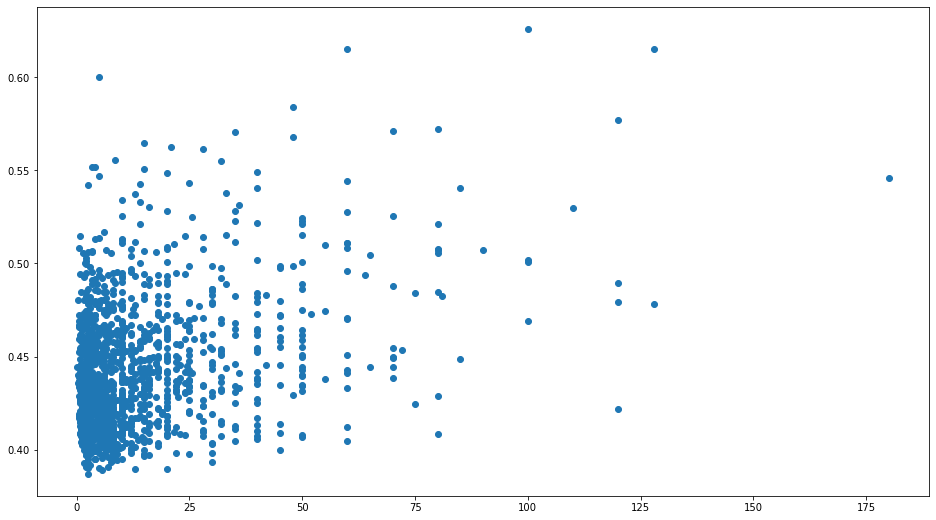

In [21]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(df.market_value_euro_millions_tm, -df.forest_score)

500

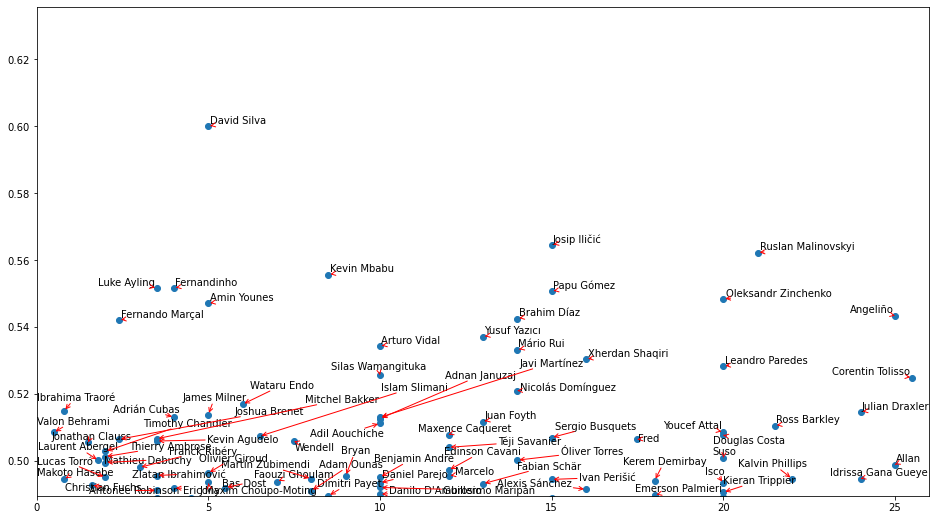

In [22]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(df.market_value_euro_millions_tm, -df.forest_score)
x_low, x_high = 0, 26
y_low, y_high = -df.forest_score.quantile(0.1), -df.forest_score.min() + 0.01
ax.set_ylim(y_low, y_high)
ax.set_xlim(x_low, x_high)
df_subset = df[(-df.forest_score >= y_low) &
               (df.market_value_euro_millions_tm <= x_high)].copy()
texts = [ax.text(df_subset.iloc[i].market_value_euro_millions_tm,
                 -df_subset.iloc[i].forest_score,
                 df_subset.iloc[i].player,
                 ha='center', va='center') for i in range(len(df_subset))]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))